# Property to rent in Luxembourg price prediction in TensorFlow with word embedding for categorical variables

In this lab I will build a neural network that would predict the price for renting a property in Luxembourg based on the input property parameters. The biggest difference comparing to many other similar models, I will be using word embedding layer for categorical columns instead of one-hot encoding. Also I will use Keras Tuner to find the best hyperparameters for my model.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

## Dataset visualisation

In this lab the dataset of current rental offers in Luxembourg is used. These offers are actual on the date of the end of November.

In [ ]:
def make_region(x):
    if pd.isna(x['luxembourg_ville_district']) == False:
        return F"{x['commune']}:{x['luxembourg_ville_district']}"
    return F"{x['commune']}"

In [ ]:
df = pd.read_csv("/content/rent_listings.csv") #set Date to become index
price_filter = lambda x: ((x['price'] > 300) & (x['price'] < 10000))
df = df.loc[price_filter]
df = df[['property_surface','bedrooms_count','has_cave','has_carparking','has_balcony',
         'has_private_garden','is_furnished','has_elevator','property_type','has_pool','commune','luxembourg_ville_district','price']]
df['region'] = lambda x: x['commune'] + ':' + x['luxembourg_ville_district']
df['region'] = df.apply(lambda x: make_region(x), axis = 1)
df.pop('commune')
df.pop('luxembourg_ville_district')
df.head()

,property_surface,bedrooms_count,has_cave,has_carparking,has_balcony,has_private_garden,is_furnished,has_elevator,property_type,has_pool,price,region
0,250.0,3,True,False,False,True,True,False,house,False,6500.0,luxembourg:centre-ville
1,91.0,2,False,True,False,False,True,True,apartment,False,2600.0,luxembourg:centre-ville
2,95.0,2,False,False,False,False,False,True,apartment,False,2800.0,luxembourg:weimerskirch
3,198.0,5,True,True,True,True,False,False,house,False,3300.0,dippach
4,53.0,1,False,True,True,False,False,False,apartment,False,1300.0,dudelange


In [ ]:
print(F"regions count = {len(list(np.unique(df['region'])))}")
print(F"property types count = {len(list(np.unique(df['property_type'])))}")

regions count = 98
property types count = 15


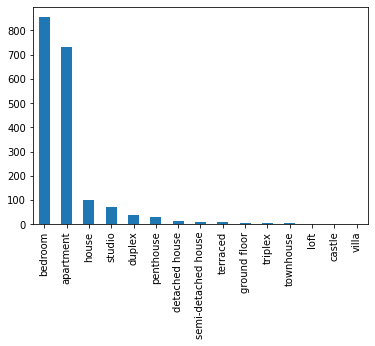

In [ ]:
df['property_type'].value_counts().plot(kind='bar')

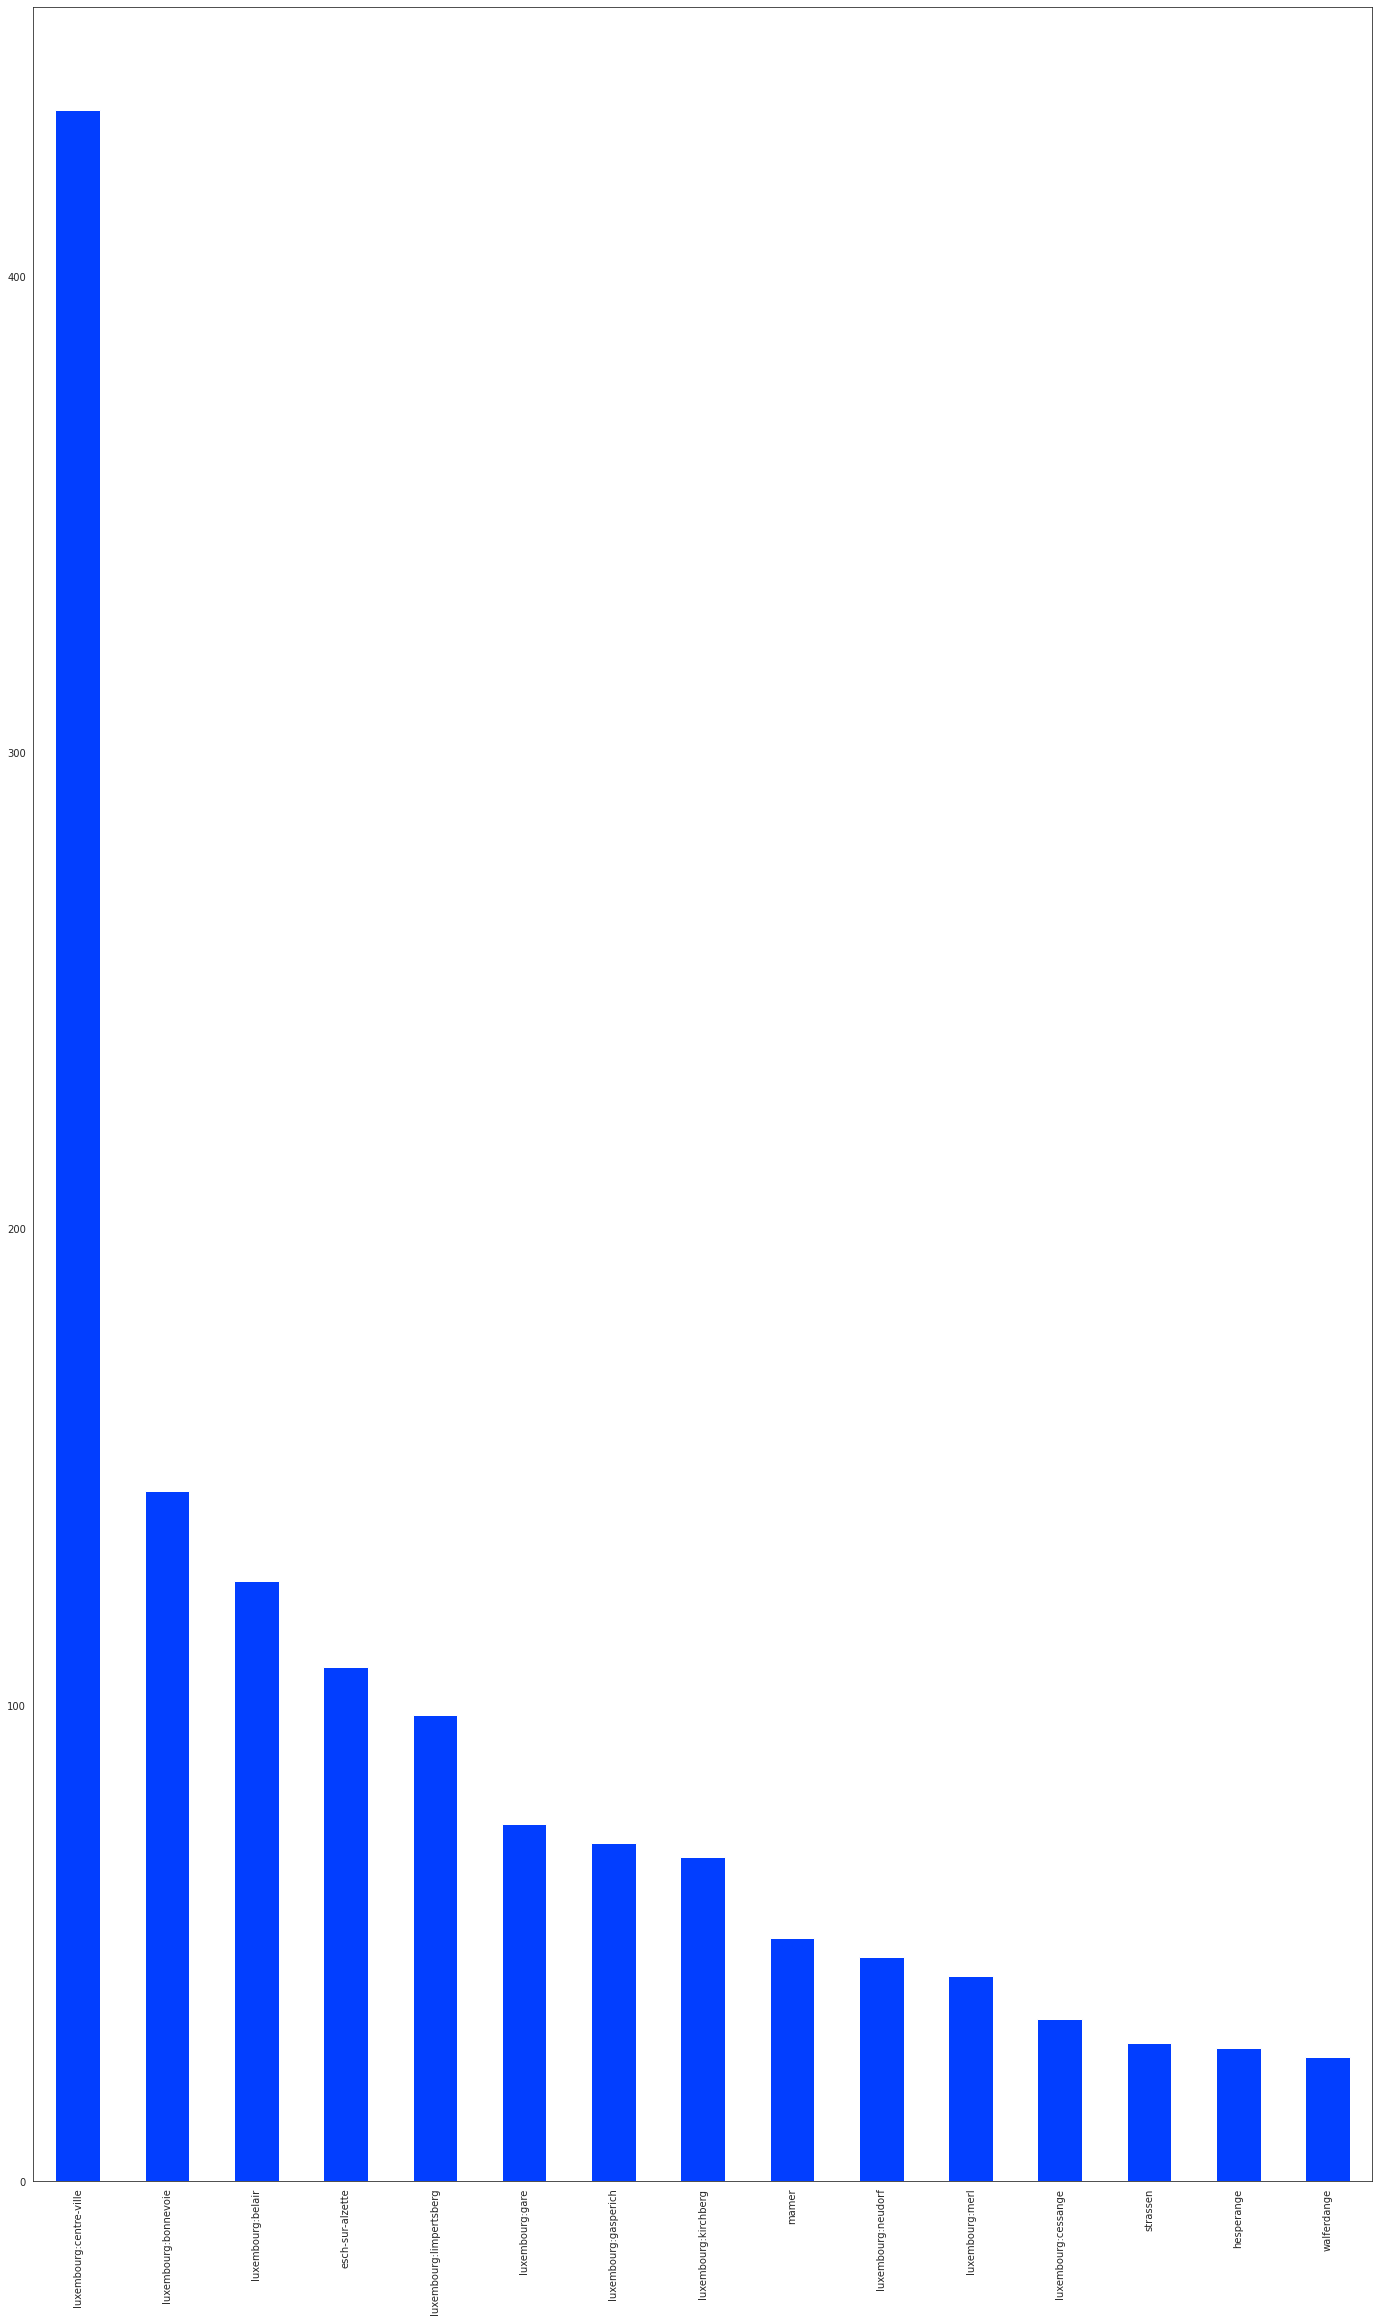

In [ ]:
df['region'].value_counts()[:15].plot(kind='bar')

In [ ]:
def display_stat():
    for i in range(2):
        mean = train_x[num_cols[i]].mean()
        std = train_x[num_cols[i]].std()
        skew = train_x[num_cols[i]].skew()
        kurtosis = train_x[num_cols[i]].kurtosis()
        print(num_cols[i]+':')
        print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))

### Distributions for key columns

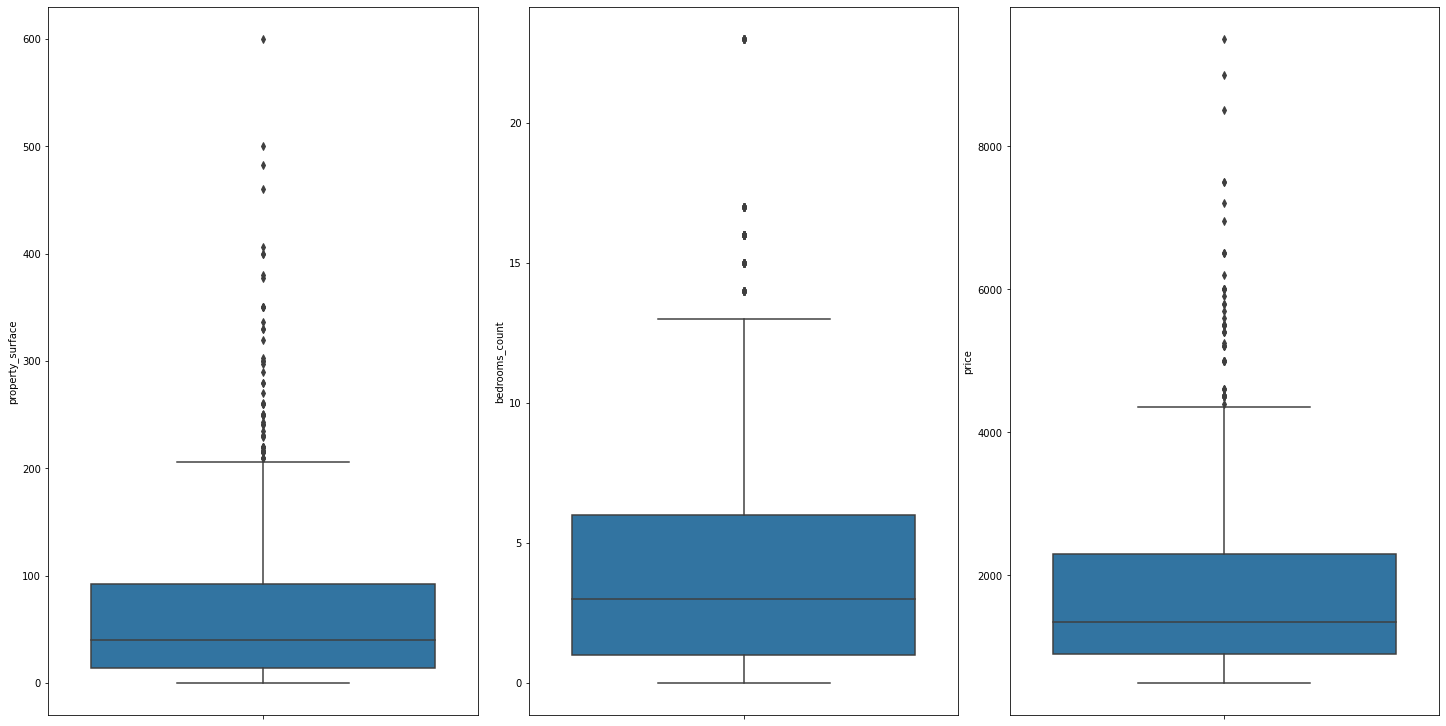

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    if k in ('bedrooms_count','property_surface','price'):
      sns.boxplot(y=k, data=df, ax=axs[index])
      index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
for k, v in df.items():
    if k in ('property_surface','bedrooms_count','price'):
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))


Column property_surface outliers = 3.09%
Column bedrooms_count outliers = 5.44%
Column price outliers = 3.20%


The neural network is unaffected by the outliers impact when the percentage-outliers in the training data is lower than 15%.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

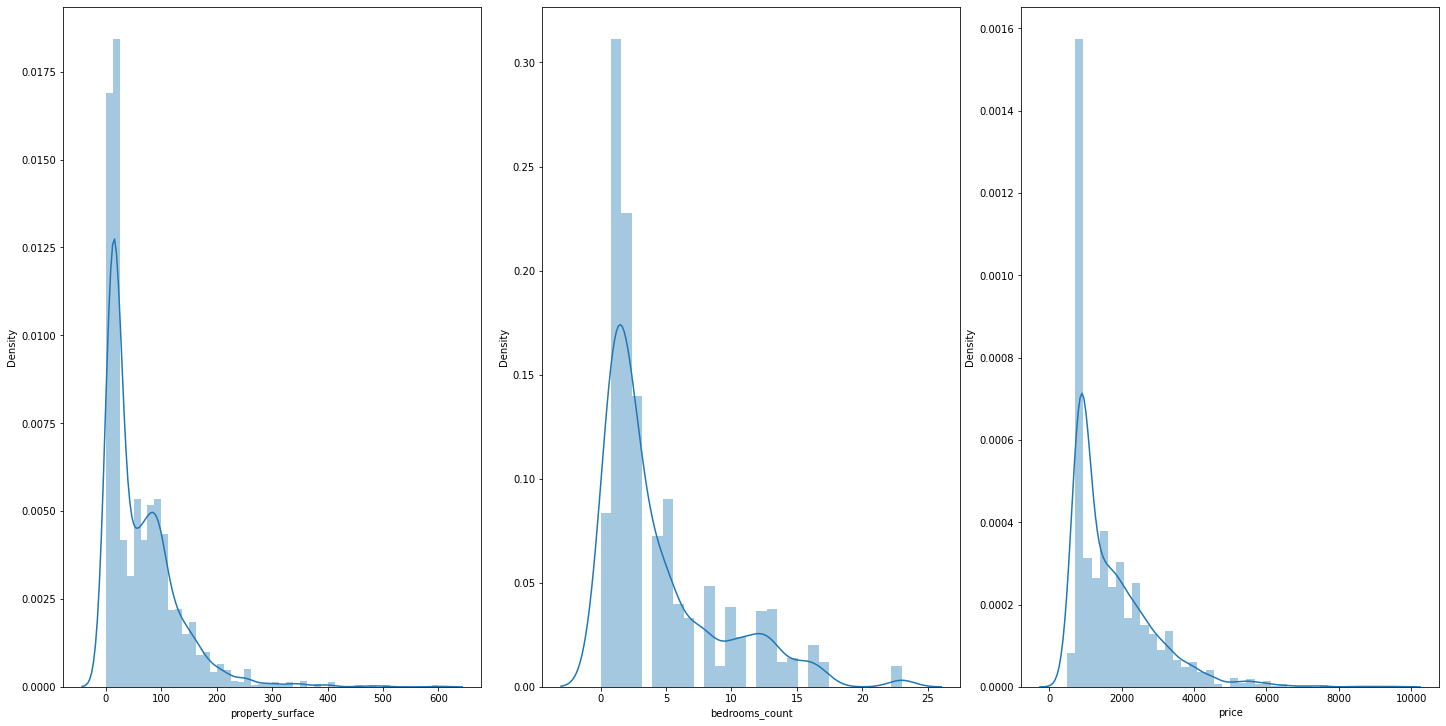

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    if k in ('bedrooms_count','property_surface','price'):
        sns.distplot(v, ax=axs[index])
        index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

All of these metrics are quite skewed. Property surface is highly skewed.

In [ ]:
df_mean = df.mean()
df_std = df.std()

df_normalized = (df - df_mean) / df_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

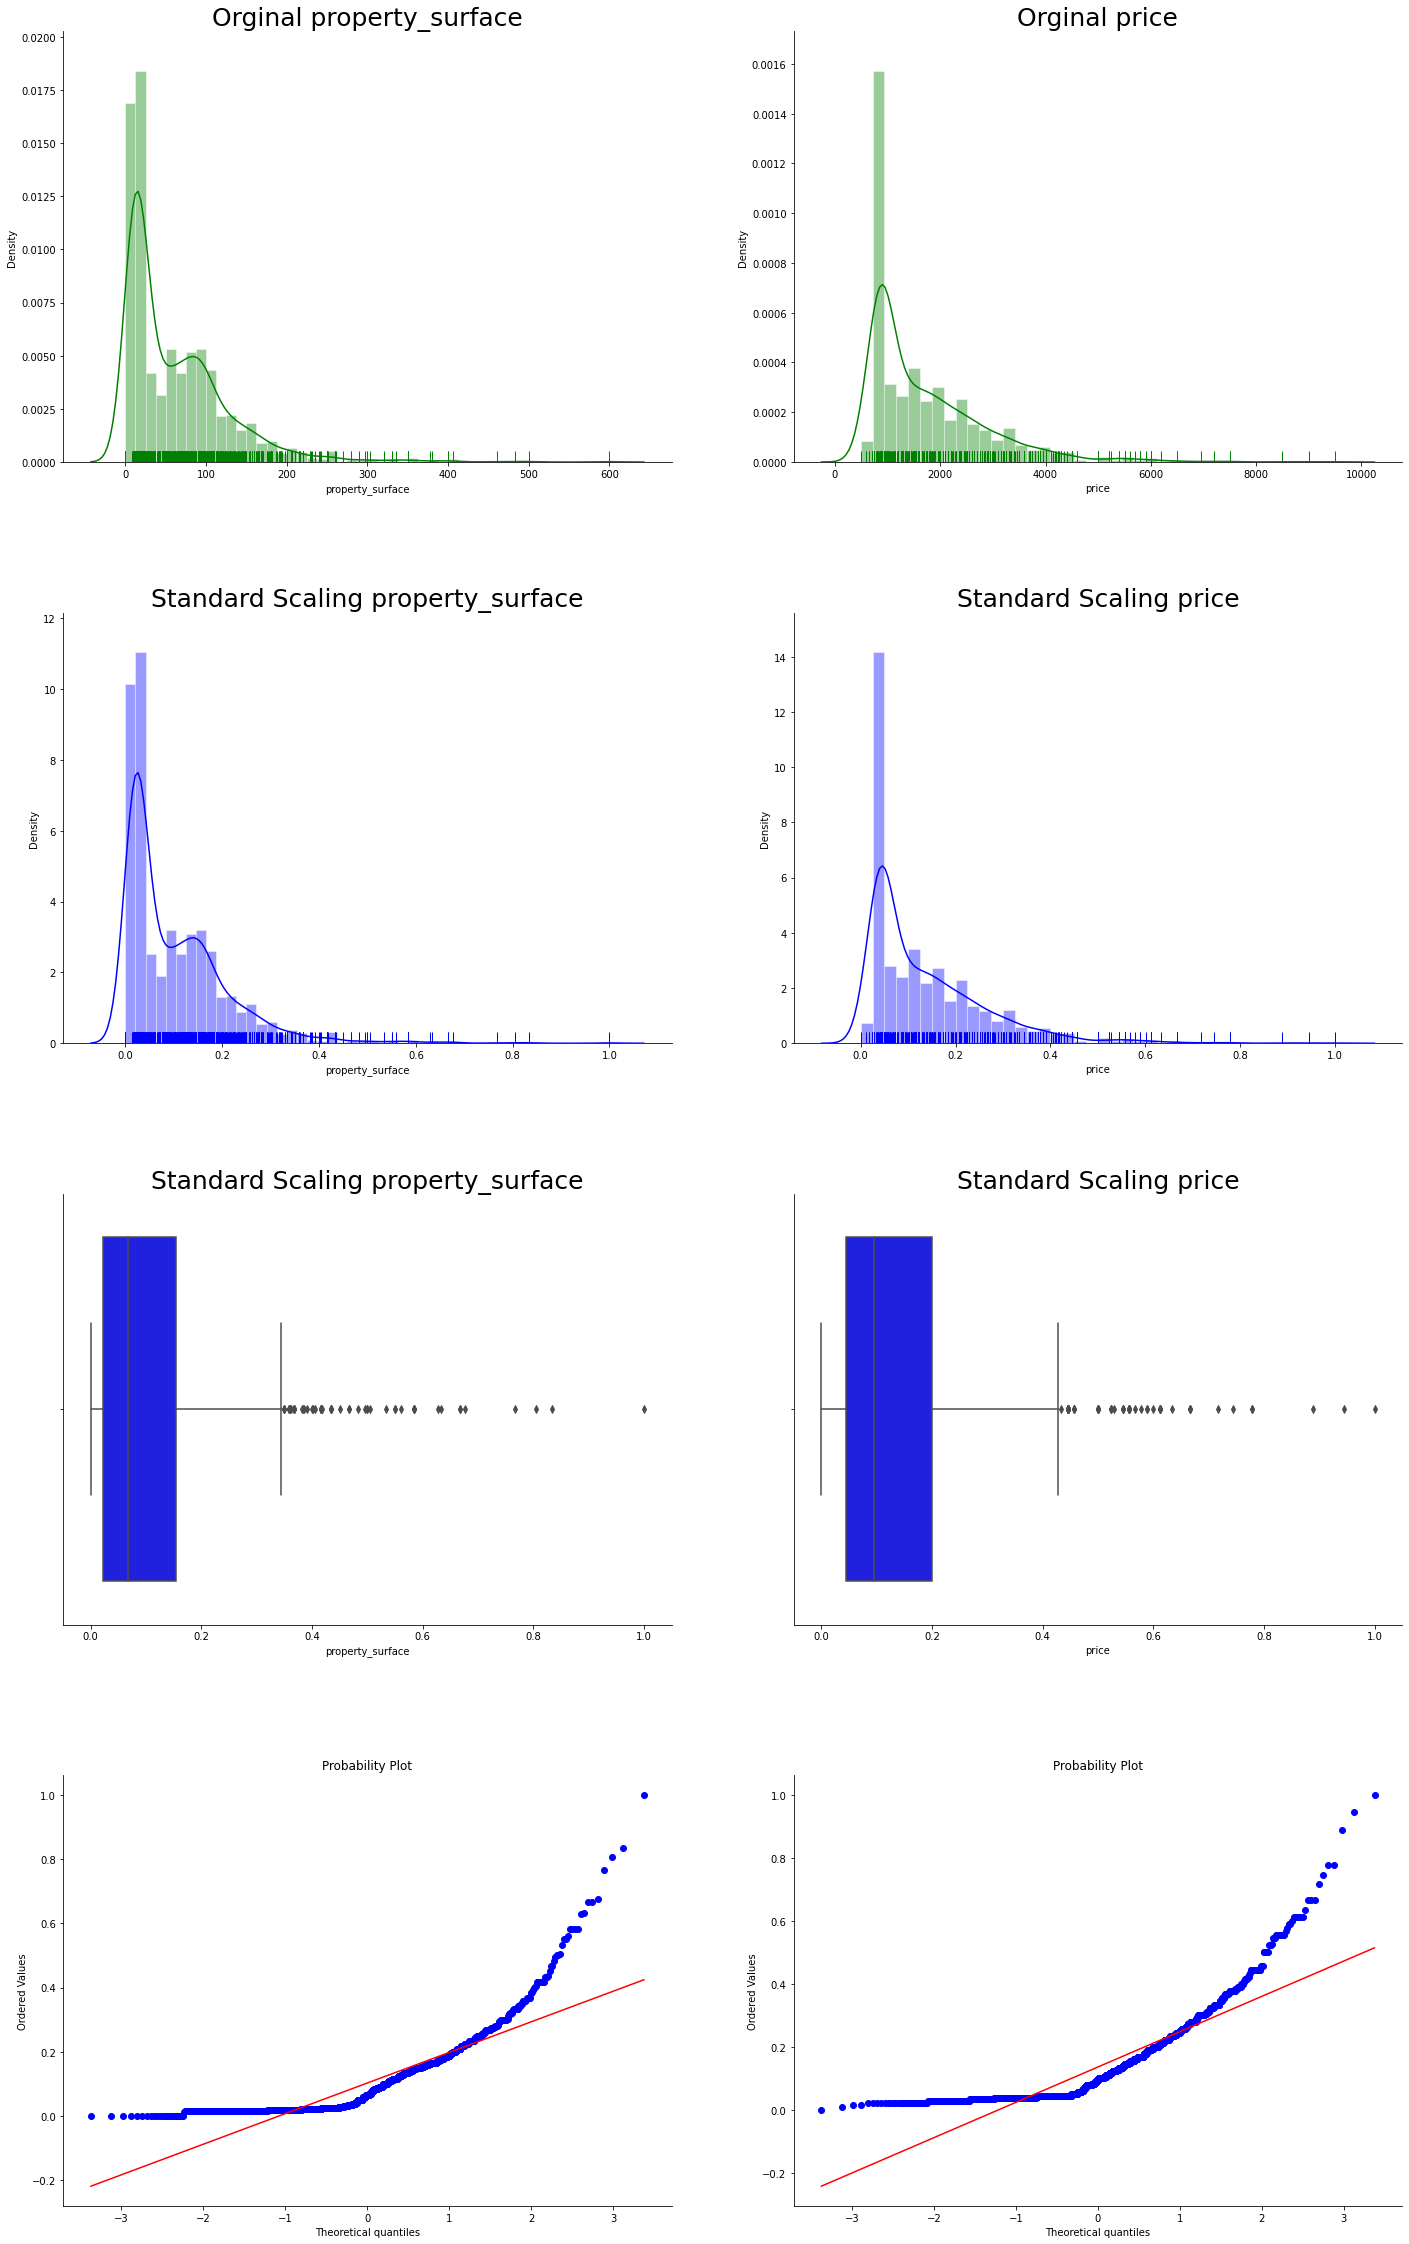

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams

train_x = df.copy()
train_org = train_x.copy()
rcParams['figure.figsize'] = 24,40
fig, axes = plt.subplots(4, 2)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.35)

num_cols = ['property_surface','price']

scaler = MinMaxScaler()
for i in range(2):
    train_x.loc[:,num_cols[i]] = scaler.fit_transform(train_x[[num_cols[i]]])
    sns.distplot(train_org.loc[:,num_cols[i]],ax=axes[0,i],rug=True,color='green')
    axes[0,i].set_title('Orginal '+num_cols[i],fontsize=25)
    sns.distplot(train_x.loc[:,num_cols[i]],ax=axes[1,i],rug=True,color='blue')
    axes[1,i].set_title('Standard Scaling '+num_cols[i],fontsize=25)
    sns.boxplot(train_x.loc[:,num_cols[i]],ax=axes[2,i],color='blue')
    axes[2,i].set_title('Standard Scaling '+num_cols[i],fontsize=25)
    stats.probplot(train_x[num_cols[i]],plot = axes[3,i])
    sns.despine()

In [ ]:
display_stat()

property_surface:
mean: 0.1031, std: 0.1077, skew: 2.1936, kurtosis: 8.1841 
price:
mean: 0.1374, std: 0.1251, skew: 1.8896, kurtosis: 5.1773 


The distribution is mapped between 0 and 1 while maintaining the shape of the original distribution.
Skewness and kurtosis did not change from the original distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

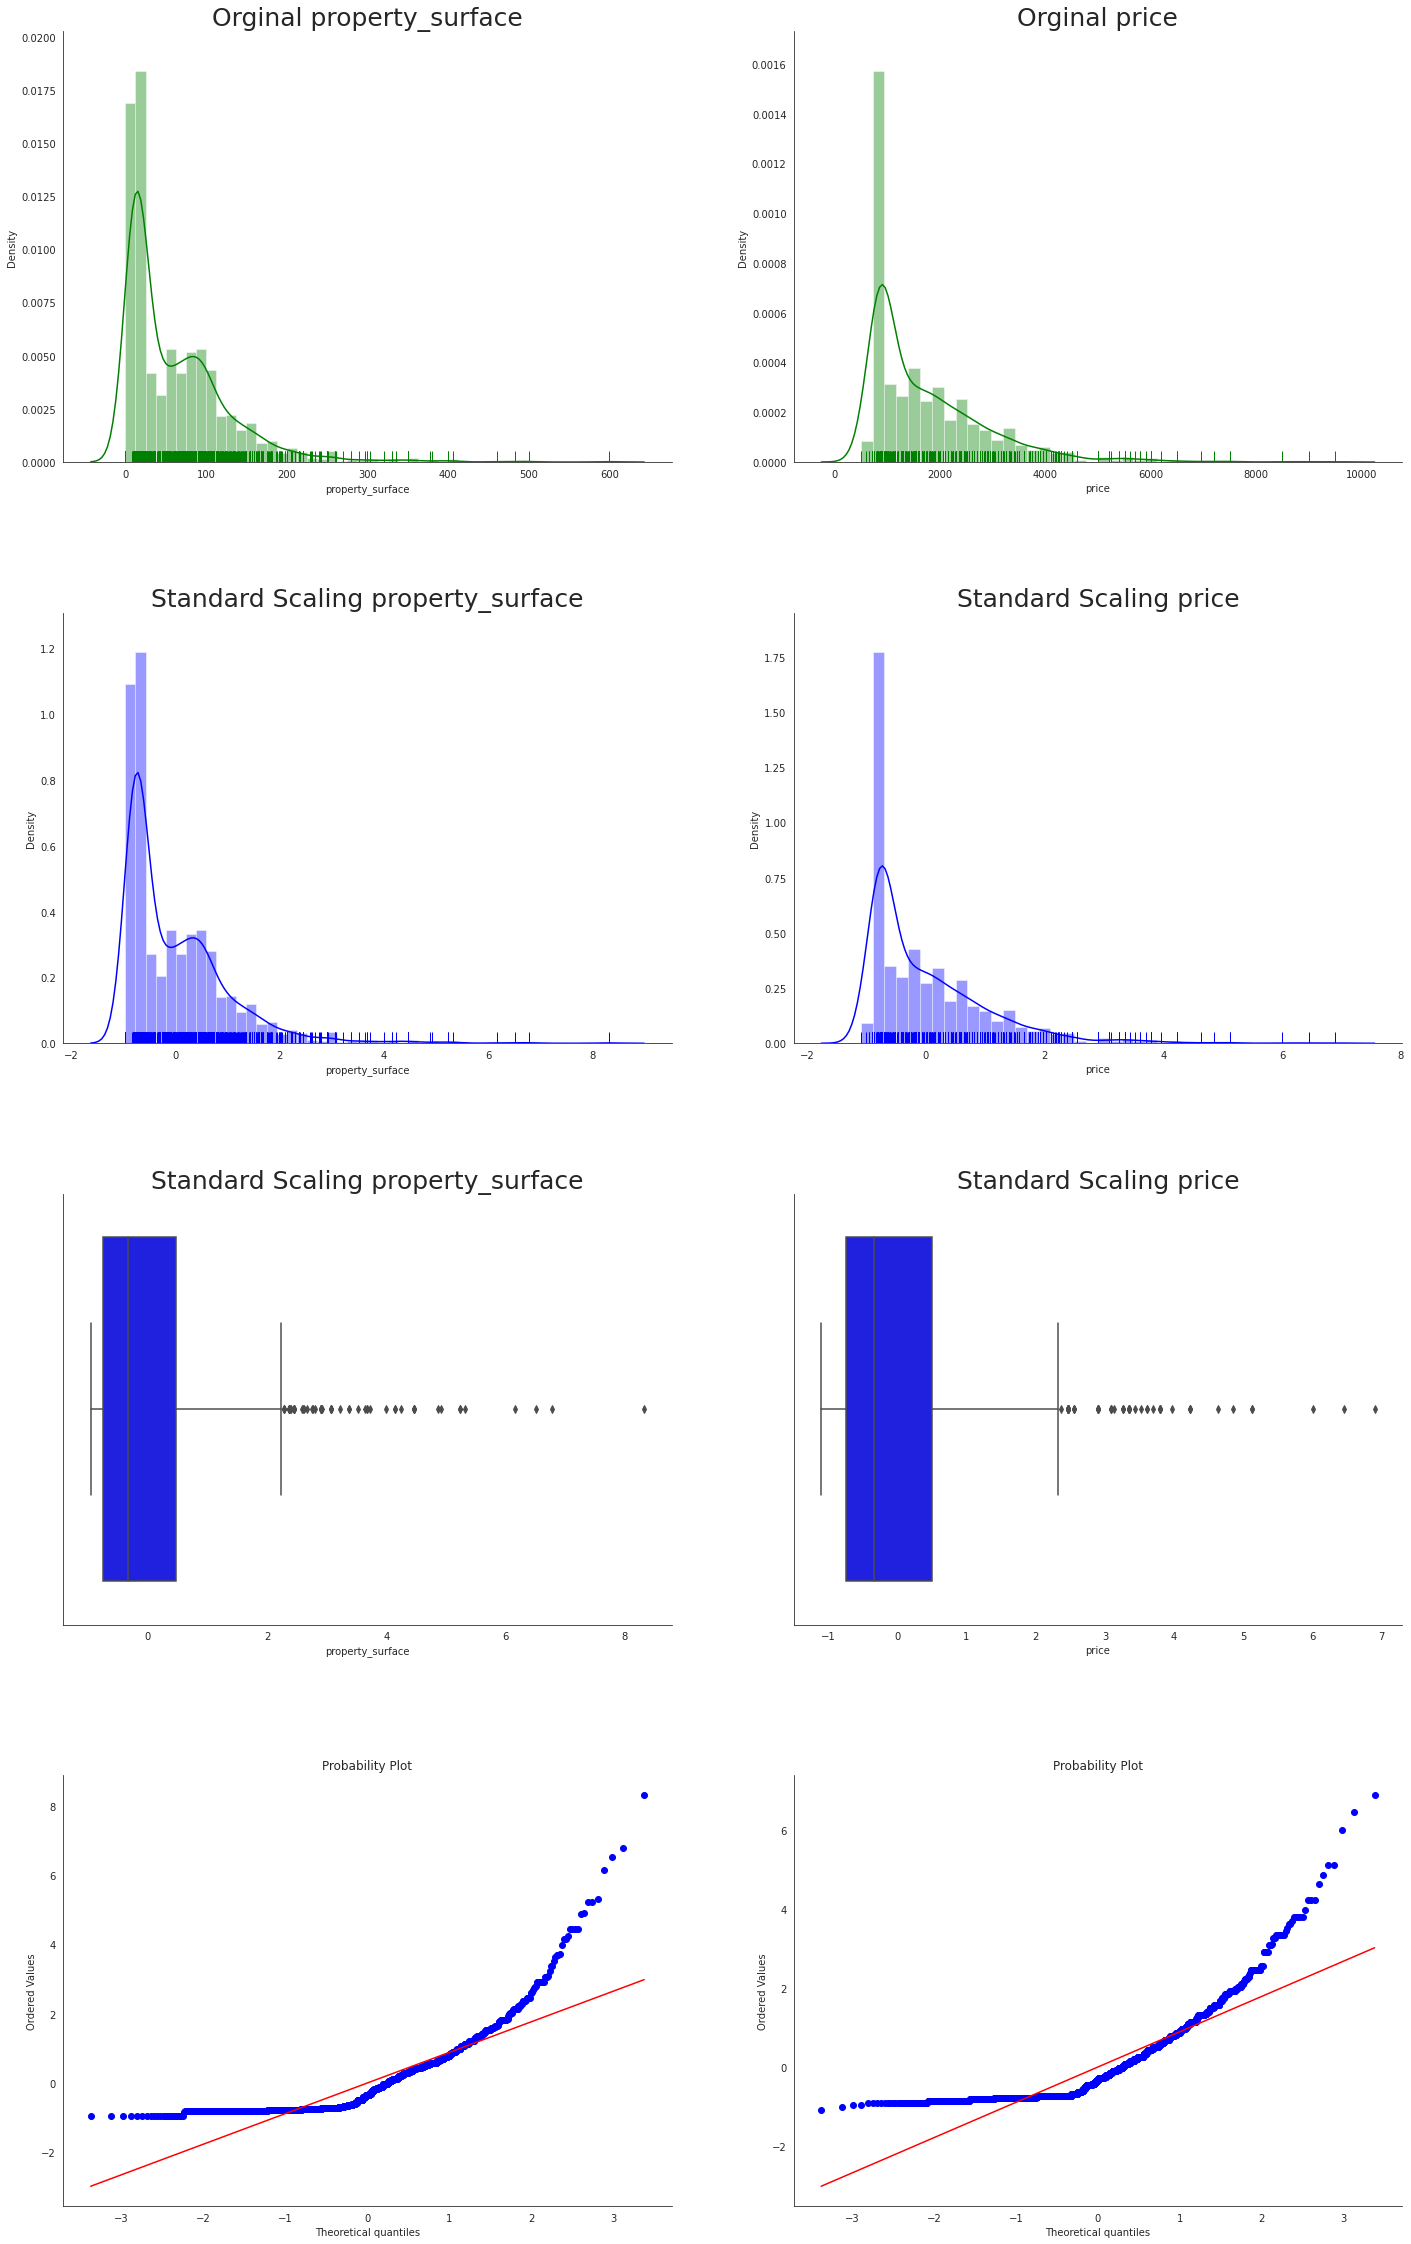

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams

train_x = df.copy()
train_org = train_x.copy()
rcParams['figure.figsize'] = 24,40
fig, axes = plt.subplots(4, 2)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.35)

num_cols = ['property_surface','price']

train_x = df_normalized.copy()
train_org = train_x.copy()
for i in range(2):
    sns.distplot(df.loc[:,num_cols[i]],ax=axes[0,i],rug=True,color='green')
    axes[0,i].set_title('Orginal '+num_cols[i],fontsize=25)
    sns.distplot(df_normalized.loc[:,num_cols[i]],ax=axes[1,i],rug=True,color='blue')
    axes[1,i].set_title('Standard Scaling '+num_cols[i],fontsize=25)
    sns.boxplot(df_normalized.loc[:,num_cols[i]],ax=axes[2,i],color='blue')
    axes[2,i].set_title('Standard Scaling '+num_cols[i],fontsize=25)
    stats.probplot(df_normalized[num_cols[i]],plot = axes[3,i])
    sns.despine()

In [ ]:
display_stat()

property_surface:
mean: 0.0000, std: 1.0000, skew: 2.1936, kurtosis: 8.1841 
price:
mean: 0.0000, std: 1.0000, skew: 1.8896, kurtosis: 5.1773 


The distribution was changed to the standard normal distribution.
Skewness and kurtosis did not change from the original distribution.

The distribution was changed to the standard normal distribution. Skewness and kurtosis did not change from the original distribution.
Power transformations are very helpful in models based on distances like K-Means, KNN. Models based on trees and neural networks are not effected by the symmetry of the features, so MinMaxScaler can be a good choice.

# Building a model: Functional API Data Pre-processing

In [ ]:
x_features = df.copy()
y = x_features.pop('price')

In [ ]:
inputs = {}

for name, column in x_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'property_surface': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'property_surface')>,
 'bedrooms_count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bedrooms_count')>,
 'has_cave': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_cave')>,
 'has_carparking': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_carparking')>,
 'has_balcony': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_balcony')>,
 'has_private_garden': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_private_garden')>,
 'is_furnished': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'is_furnished')>,
 'has_elevator': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_elevator')>,
 'property_type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'property_type')>,
 'has_pool': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_pool')>,
 'region': <KerasTe

In [ ]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

In [ ]:
numeric_inputs

{'property_surface': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'property_surface')>,
 'bedrooms_count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bedrooms_count')>,
 'has_cave': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_cave')>,
 'has_carparking': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_carparking')>,
 'has_balcony': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_balcony')>,
 'has_private_garden': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_private_garden')>,
 'is_furnished': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'is_furnished')>,
 'has_elevator': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_elevator')>,
 'has_pool': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_pool')>}

In [ ]:
x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(np.array(df[numeric_inputs.keys()]).astype(np.float32))
all_numeric_inputs = normalization_layer(x)

# As a result we will have a symbolic tensor representing concatenation of all numeric features
all_numeric_inputs

<KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'normalization')>

The default settings for the tf.keras.layers.CategoryEncoding layer create a one-hot vector for each input. A tf.keras.layers.Embedding would also work. https://www.tensorflow.org/tutorials/load_data/csv

Embedding layer is used here

In [ ]:
preprocessed_inputs = [all_numeric_inputs]
preprocessed_inputs

[<KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'normalization')>]

In [ ]:
embedding_dimension = 8
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  vocab_array=np.unique(x_features[name])
  input_lookup = tf.keras.layers.StringLookup(vocabulary = vocab_array, mask_token = None)
  embedding_layer= tf.keras.Sequential([
      input_lookup,
      tf.keras.layers.Embedding(len(vocab_array) + 1, embedding_dimension)
    ], name=F'embedding_{name}')

  x = embedding_layer(input)
  x = tf.squeeze(x,1)
  preprocessed_inputs.append(x)

In [ ]:
preprocessed_inputs

[<KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'tf.compat.v1.squeeze')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'tf.compat.v1.squeeze_1')>]

So at the end we have a concatenation layer with 25 features (9 numeric and twice by 8 embedding features)

In [ ]:
preprocessed_inputs_mixed = tf.keras.layers.Concatenate()(preprocessed_inputs)
preprocessed_inputs_mixed

<KerasTensor: shape=(None, 25) dtype=float32 (created by layer 'concatenate_1')>

In [ ]:
features_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_mixed)

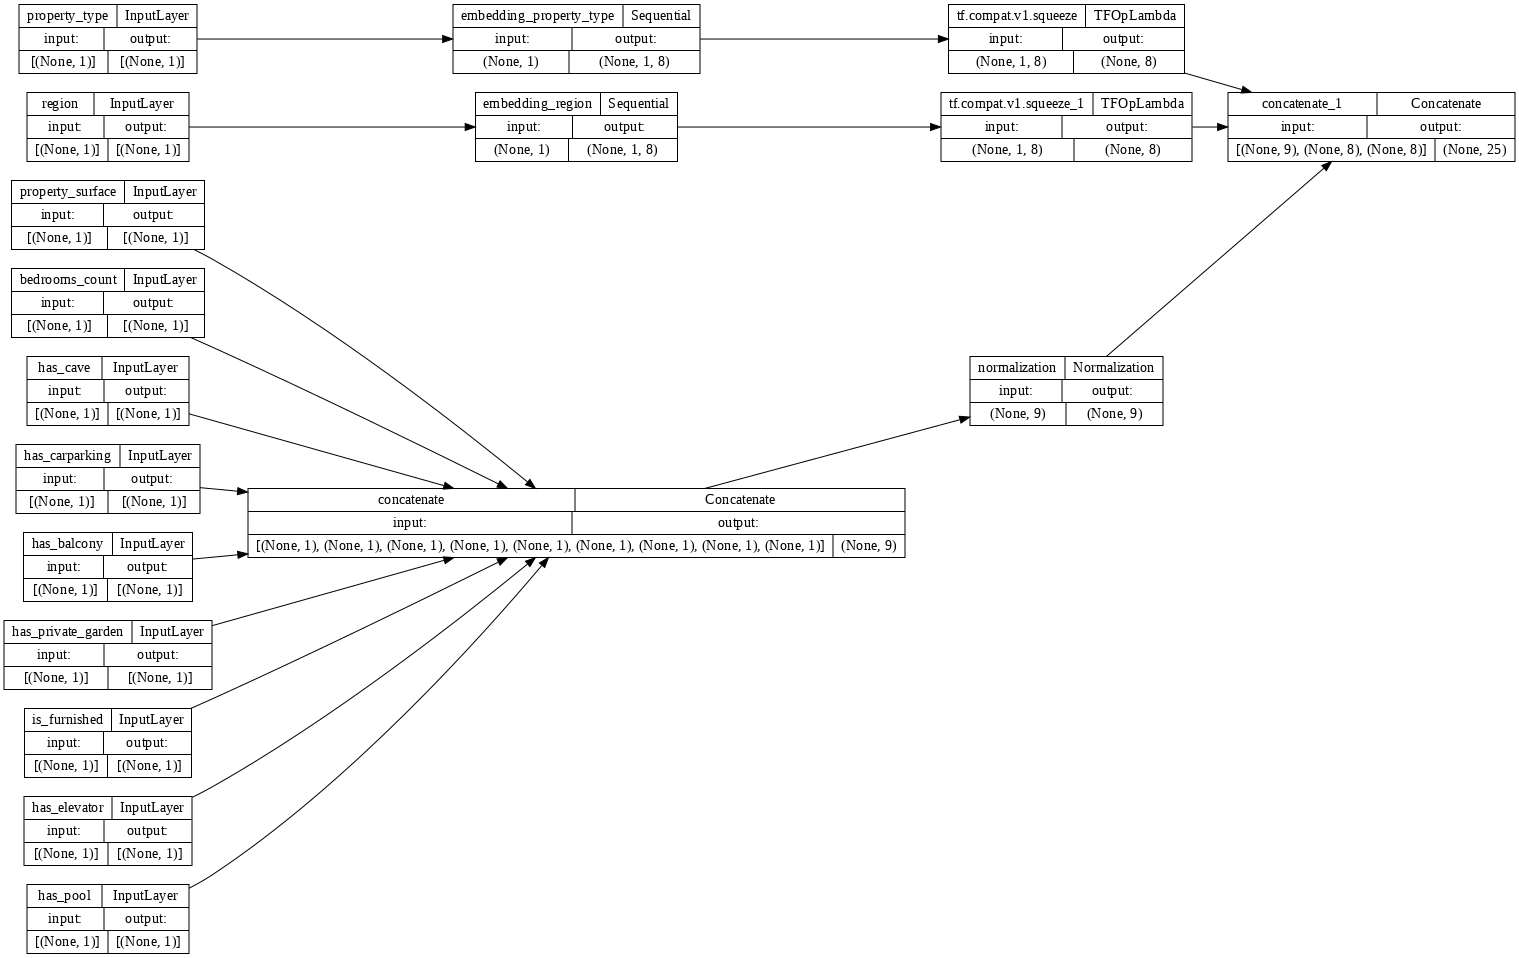

In [ ]:
tf.keras.utils.plot_model(model = features_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

# Model

[Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) can help to tune hyperparameters in the model: the number of units for both dense layers and the learning rate for the Optimizer.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_features, y, train_size=0.75, random_state=42)

In [ ]:
X_train_all = {name: np.array(value) 
                         for name, value in x_features.items()}

In [ ]:
X_train_np = {name: np.array(value) 
                         for name, value in X_train.items()}
X_val_np = {name: np.array(value) 
                         for name, value in X_val.items()}    

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

In [ ]:
def property_rent_model_builder(hp, preprocessing_head, inputs):
  body = tf.keras.Sequential([])
  hp_units = hp.Int('units_layer_64', min_value=16, max_value=1024, step=32)
  body.add(tf.keras.layers.Dense(64, name='layer_64', activation = 'relu'))
  hp_units = hp.Int('units_layer_128', min_value=16, max_value=1024, step=32)
  body.add(tf.keras.layers.Dense(128, name='layer_128', activation = 'relu' ))
  body.add(tf.keras.layers.Dense(1, name='final_layer'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics = ['mae'])
  return model

Because we need to pass multiple args to this model builder, we wrap it in partial in order to pass to Keras Tuner.

In [ ]:
from functools import partial
build_model = partial(property_rent_model_builder, preprocessing_head = features_preprocessing, inputs = inputs)

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     max_epochs=300,
                     factor=3,
                     directory='my_dir',
                     project_name='property_rent_model_kt1')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

In [ ]:
tuner.search(X_train_all, y, epochs=300, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_layer_64')} and in the second {best_hps.get('units_layer_128')} 
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 725 Complete [00h 00m 12s]
val_mae: 284.82733154296875

Best val_mae So Far: 244.8623046875
Total elapsed time: 00h 37m 55s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 304 and in the second 16 
and the optimal learning rate for the optimizer
is 0.01.



In [ ]:
best_hps.values

{'units_layer_64': 304,
 'units_layer_128': 16,
 'learning_rate': 0.01,
 'tuner/epochs': 300,
 'tuner/initial_epoch': 100,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0697'}

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 150 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_all, y, epochs=150, validation_split=0.2)

Epoch 1/300
47/47 [==============================] - 1s 9ms/step - loss: 1507997.0000 - mae: 844.7856 - val_loss: 397539.0938 - val_mae: 411.8660
Epoch 2/300
47/47 [==============================] - 0s 4ms/step - loss: 356074.1562 - mae: 352.6051 - val_loss: 351846.8125 - val_mae: 355.0062
Epoch 3/300
47/47 [==============================] - 0s 4ms/step - loss: 316273.2188 - mae: 331.9876 - val_loss: 318859.9688 - val_mae: 373.0537
Epoch 4/300
47/47 [==============================] - 0s 4ms/step - loss: 280168.3438 - mae: 310.7016 - val_loss: 289921.4375 - val_mae: 325.6283
Epoch 5/300
47/47 [==============================] - 0s 4ms/step - loss: 256945.3906 - mae: 296.4367 - val_loss: 288704.0625 - val_mae: 329.7887
Epoch 6/300
47/47 [==============================] - 0s 4ms/step - loss: 231878.8281 - mae: 286.7477 - val_loss: 274289.4375 - val_mae: 311.1353
Epoch 7/300
47/47 [==============================] - 0s 5ms/step - loss: 213412.1875 - mae: 272.3874 - val_loss: 254477.5469 - va

In [ ]:
val_mae_per_epoch = history.history['val_mae']
best_epoch = val_mae_per_epoch.index(min(val_mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
print('Best val_mae %d'%min(val_mae_per_epoch))

Best epoch: 34
Best val_mae 228


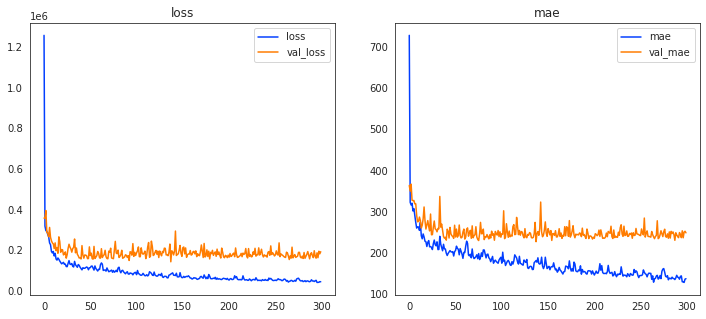

In [ ]:
def plot(history):
    fig, axs = plt.subplots(1,2, figsize=(12, 5))

    hist = history.history

    for ax, metric in zip(axs, ["loss", "mae"]):
        ax.plot(hist[metric])
        ax.plot(hist["val_"+metric])
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)

plot(history)

If we print the train/validation graph for MAE by epochs, we can see that after around 100 epochs the validation MAE stagnates, so there's no need to run for many epochs in this case.

# Predictions

Predicting on the first record from the initial dataset and comparing to the original value

In [ ]:
features_dict = {name:values[:1] for name, values in x_features.items()}
predicted = model.predict(features_dict)

1/1 [==============================] - 0s 113ms/step


The predicted value is quite close to the original value in the initial dataset.

In [ ]:
predicted[0][0]

6628.4097

Prediction on the imaginary rent offer.

In [ ]:
new_rent_offers = {'property_surface':pd.Series([55.0]), 'bedrooms_count':pd.Series([1]),'has_cave':pd.Series([True]), 
                    'has_carparking':pd.Series([False]), 'has_balcony': pd.Series([True]), 'has_private_garden': pd.Series([False]), 
                    'is_furnished': pd.Series([False]), 'has_elevator': pd.Series([True]), 'property_type': pd.Series(['apartment']),
                    'has_pool': pd.Series([False]), 'region': pd.Series(['luxembourg:centre-ville'])}
predicted_new_offers_prices = model.predict(new_rent_offers)
print(F'The predicted estimated price for renting this place is {round(predicted_new_offers_prices[0][0])} eur/month')

1/1 [==============================] - 0s 30ms/step
The predicted estimated price for renting this place is 1770 eur/month


In [ ]:
predicted_new_offers_prices

array([[1769.8915]], dtype=float32)